# 5. Evolución de técnicas. Caso: POS tagging

<img src="https://nextcloud.tepezil.net/apps/files_sharing/publicpreview/Hiczm3M7NMTzGt4?file=/&fileId=65945&x=2560&y=1440&a=true&etag=1815fb54c51fb48b187ae17565238c81">

## Objetivos

- Describir la tarea de etiquetado *POS*
- Hacer una revisión incremental de métodos para resolver esta tarea
- Comparar el rendimiento de diferentes enfoques

## In deepth Part of Speech Tags

- Las palabras que conforman un texto tienen diferentes propiedades gramaticales y los lingüístas han propuesto categorías para agrupar las características comunes.

- Dichas clases son llamadas *Part of Speech (POS)*. Al etiquetar palabras con su respectiva POS tag hacemos explícitas ciertas propiedades gramaticales

- En *NLP*, el *POS tagging* consiste en asignar automáticamente a las palabras su *POS tag*.

### Clases de etiquetas POS

Las etiquetas POS se asignan a dos clases principales de palabras: abiertas y cerradas.

Las palabras de clase cerradas son aquellas que son relativamente estables en el tiempo y que tienen un rol funcional. Incluyen palabras como artículos, determinantes, pronombres, por mencionar algunas.

Las palabras de clases abiertas conforman el grueso del vocabulario. Todas las palabras "nuevas" que se van creando caerían en esta categoría. Las palabras de clases abiertas serían sustantivos, adjetivos, verbos y adverbios.

### Gramátical features

Las categorías básicas pueden reinarse o subcategorizarse. Por ejemplo, los sustantivos pueden agrparse en singulares y plurales. Incluso dependiendo de la lengua puede que haya mas o menos subcategorias. Por ejemplo, el aleman subdivide los sustantivos por generos: másculino, femenino y neutro.

Estas propiedades adicionales que especifican las categorías principales son llamadas **gramatical features**. Estas categorias varian dependiendo de las lenguas e incluyen numero, genero, persona, caso y tiempo, entre otras.

Cada sub-categoria tendrá un conjunto de valores posibles y variaran tambien con base en la etiqueta POS.

### POS tagging como desambiguación

Podemos pensar en el etiquetado POS como una tarea de desambigüación ya que las palabras pueden tener más de una etiqueta POS asociada. El objetivo será encontrar la etiqueta adecuada.

Ejemplos de palabras con etiquetas ambigüas:

- *book*
  - "**book/VERB** that flight"
  - "hand me that **book/NOUN**"
- *that*
  - "**That/DET** white table"
  - "Is not **that/ADV** easy"

In [1]:
# HIT: Restart session
!pip install numpy==1.26.4
!pip install -U gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


## Corpus

### https://universaldependencies.org/

In [1]:
URL = "https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-AnCora/refs/heads/master/es_ancora-ud-train.conllu"

In [65]:
import requests
from rich import print as rprint

raw_data = requests.get(URL).text

In [66]:
rprint(raw_data[:1000])

# global.Entity = eid-etype-head-other
# newdoc id = 3LB-CAST-104_c-1
# sent_id = 3LB-CAST-104_c-1-s1
# text = Las reservas de oro y divisas de Rusia subieron 800 millones de dólares y el 26 de mayo equivalían a 
19.100 millones de dólares, informó hoy un comunicado del Banco Central.
# orig_file_sentence 001#58
1       Las     el      DET     da0fp0  Definite=Def|Gender=Fem|Number=Plur|PronType=Art        2       det     
2:det   _
2       reservas        reserva NOUN    ncfp000 Gender=Fem|Number=Plur  9       nsubj   9:nsubj ArgTem=arg1:tem
3       de      de      ADP     sps00   _       4       case    4:case  _
4       oro     oro     NOUN    ncms000 Gender=Masc|Number=Sing 2       nmod    2:nmod  ArgTem=arg1:pat
5       y       y       CCONJ   cc      _       6       cc      6:cc    _
6       divisas divisa  NOUN    ncfp000 Gender=Fem|Number=Plur  4       conj    4:conj  _
7       de      de      ADP     sps00   _       8       case    8:case  _
8       Rusia   Rusia   PROPN   np0000l _       2       nmod    2:nmod  
ArgTem=arg0:agt|Entity=(NOCOREF:Spec.location-place-1-gstype:spec)
9       subieron        subir   VERB    vmis3p0 Mood=Ind|Number=Plur|Person=3|Tense=Past|VerbForm=Fin   26      
ccomp   26:ccomp        ArgTem=arg1:pat
10      800     800     NUM     _       NumForm=Digit|NumType=Ca

### Estandarización de POS tagsets y grammatical features: formato CoNLL

Hay dos esquemas de anotación populares:

1. El *Universal Part-of-Speech Tagset (UPOS)* para etiquetas POS
2. MULTEXT para *grammatical features*

Estos formatos fueron adoptados en los shared tasks de *The Conference on Natural Language Learning (CoNLL)* convirtiendose en el estandar *de facto* para entrenar modelos de *machine-learning* para resolver diversas tareas como: POS tagging, parse mofphologico, parseo de dependencias, entre otros.

In [4]:
def get_raw_corpus(lang: str) -> str:
    """Obtiene el corpus crudo de Universal Dependencies

    Parameters
    ----------
    lang: str
        Idioma del corpus. Puede ser "es" o "en"

    Return
    ------
    str
        Corpus crudo en formato CoNLL
    """
    file_variants = ["train", "test", "dev"]
    result = dict.fromkeys(file_variants)
    DATASETS = {"es": ["UD_Spanish-AnCora", "es_ancora-ud"], "en": ["UD_English-GUM", "en_gum-ud"]}
    repo, file_name = DATASETS[lang]
    for variant in file_variants:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{variant}.conllu"
        r = requests.get(url)
        result[variant] = r.text
    return result

In [5]:
raw_corpus = get_raw_corpus("en")
raw_spanish_corpus = get_raw_corpus("es")

In [68]:
rprint(raw_spanish_corpus["test"][:2500])

# global.Entity = eid-etype-head-other
# newdoc id = 3LB-CAST-111_C-4
# sent_id = 3LB-CAST-111_C-4-s1
# text = Partidario de la "perestroika" de Mijail Gorbachov en la Unión Soviética, en 1989 entró en conflicto con 
Yívkov, líder durante 35 años del Partido Comunista y del Estado búlgaro, y le acusó en una carta abierta de 
utilizar métodos poco democráticos de gobierno.
# orig_file_sentence 001#1
1       Partidario      partidario      ADJ     aq0ms0  Gender=Masc|Number=Sing 17      amod    17:amod _
2       de      de      ADP     sps00   _       5       case    5:case  _
3       la      el      DET     da0fs0  Definite=Def|Gender=Fem|Number=Sing|PronType=Art        5       det     
5:det   Entity=(NOCOREF:Spec.other-other-3-gstype:spec
4       "       "       PUNCT   fe      PunctType=Quot  5       punct   5:punct SpaceAfter=No
5       perestroika     perestroika     NOUN    ncfs000 Gender=Fem|Number=Sing  1       nmod    1:nmod  
SpaceAfter=No
6       "       "       PUNCT   fe      PunctType=Quot  5       punct   5:punct _
7       de      de      ADP     sps00   _       8       case    8:case  _
8       Mijail  Mijail  PROPN   np0000p _       5       nmod    5:nmod  
MWE=Mijail_Gorbachov|MWEPOS=PROPN|Entity=(NOCOREF:Spec.person-person-1-gstype:spec
9       Gorbachov       Gorbachov       PROPN   _       _       8       flat    8:flat  Entity=NOCOREF:Spec.person)
10      en      en      ADP     sps00   _       12      case    12:case _
11      la      el      DET     da0fs0  Definite=Def|Gender=Fem|Number=Sing|PronType=Art        12      det     
12:det  Entity=(NOCOREF:Spec.location-place-2-gstype:spec
12      Unión   Unión   PROPN   np0000l _       5       nmod    5:nmod  MWE=Unión_Soviética|MWEPOS=PROPN
13      Soviética       Soviética       PROPN   _       _       12      flat    12:flat 
SpaceAfter=No|Entity=NOCOREF:Spec.location)NOCOREF:Spec.other)
14      ,       ,       PUNCT   fc      PunctType=Comm  1       punct   1:punct _
15      en      en      ADP     sps00   _       16      case    16:case _
16      1989    1989    NOUN    _       _       17      obl     17:obl  
ArgTem=argM:tmp|Entity=(NOCOREF:Spec.date-time-1-gstype:spec)
17      entró   entrar  VERB    vmis3s0 Mood=Ind|Number=Sing|Person=3|Tense=Past|VerbForm=Fin   0       root    
0:root  _
18      en      en      ADP     sps00   _       19      case    19:case _
19      conflicto       conflicto       NOUN    ncms000 Gender=Masc|Number=Sing 17      obl     17:obl  
ArgTem=arg2:efi
20      con     con     ADP     sps00   _       21      case    21:case _
21      Yívkov  Yívkov  PROPN   np0000p _       17      obl     17:obl  
SpaceAfter=No|ArgTem=argM:adv|Entity=(NOCOREF:Spec.person-person-1-gstype:spec
22      ,       ,       PUNCT   fc      PunctType=Comm  23      punct   23:punct        
Entity=(NOCOREF:Spec.person-person-2-gstype:spec
23      líder   líder   NOUN    nccs000 Number=Sing     21      appos   21:appos        _
24      durante durante ADP     sps00   _       26      case    26:case _
25      35      35      NUM     _       NumForm=Digit|NumType=Card      26      nummod  26:nummod       _
26      años    año     NOUN    ncmp000 Gender=Masc|Number=Plur 23      nmod    23:nmod _
27-28   del     _       _       _       _       _       _       _       _
27      de      de      ADP     spcms   _       29      case    29:case _
28      el      el      DET     _       Definite=Def|Gender=Masc|Number=Sing|PronType=Art       29      det     
29:de

In [69]:
class Token(dict):
    """Modela cada renglon de un corpus en formato CoNLL
    """
    pass

In [70]:
t = Token(
    {
        "ID": "1",
        "FORM": "Las",
        "LEMMA": "el",
        "UPOS": "DET",
        "FEATS": "Definite=Def|Gender=Fem|Number=Plur|PronType=Art",
    }
)
rprint(t)

{
    'ID': '1',
    'FORM': 'Las',
    'LEMMA': 'el',
    'UPOS': 'DET',
    'FEATS': 'Definite=Def|Gender=Fem|Number=Plur|PronType=Art'
}

In [9]:
import re

class CoNLLDictorizer:
    """Convierte un corpus en formato CoNLL a una lista de diccionarios

    Define los métodos fit, transform y fit_transform para que
    sea compatible con la api de scikit-learn.

    Parameters
    ----------
    column_names: list
        Nombre de las columnas del corpus.
        Default: ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]
    sent_sep: str
        Separador de oraciones. Default: "\n\n"
    col_sep: str
        Separador de columnas. Default: "\t+"
    """
    DEFAULT_COLS = [
        "ID",
        "FORM",
        "LEMMA",
        "UPOS",
        "XPOS",
        "FEATS",
        "HEAD",
        "DEPREL",
        "HEAD",
        "DEPS",
        "MISC",
    ]

    def __init__(self, column_names: list=DEFAULT_COLS, sent_sep="\n\n", col_sep="\t+"):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus: str) -> list[Token]:
        """Convierte un corpus en formato CoNLL a una lista de diccionarios.

        Parameters
        ----------
        corpus: str
            Corpus en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens del corpus
        """
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence: list[str]) -> list[Token]:
        """Preprocesa una oración en formato CoNLL

        Ignora las lineas que comienzan con "#" y separa
        cada línea en un diccionario.

        Parameters
        ----------
        sentence: str
            Oracion en formato CoNLL

        Return
        ------
        list
            Lista de diccionarios con los tokens de la oración
        """
        rows = re.split("\n", sentence)
        rows = [row for row in rows if row[0] != "#"]
        return [
            Token(dict(zip(self.column_names, re.split(self.col_sep, row))))
            for row in rows
        ]

In [71]:
conll_dict = CoNLLDictorizer()

In [72]:
corpora = {}
for variant in ["train", "test", "dev"]:
    corpora[variant] = conll_dict.transform(raw_corpus[variant])

In [73]:
spanish_corpora = {}
for variant in ["train", "test", "dev"]:
    spanish_corpora[variant] = conll_dict.transform(raw_spanish_corpus[variant])

In [13]:
rprint(corpora["train"][0])

[
    {
        'ID': '1',
        'FORM': 'Aesthetic',
        'LEMMA': 'aesthetic',
        'UPOS': 'ADJ',
        'XPOS': 'JJ',
        'FEATS': 'Degree=Pos',
        'HEAD': '2:amod',
        'DEPREL': 'amod',
        'DEPS': 
'Discourse=organization-heading:1->57:8:grf-ly-+sem-lxchn-4,619+sem-lxchn-5,620|Entity=(1-abstract-new-cf1-2-sgl|MS
eg=Aesthet-ic'
    },
    {
        'ID': '2',
        'FORM': 'Appreciation',
        'LEMMA': 'appreciation',
        'UPOS': 'NOUN',
        'XPOS': 'NN',
        'FEATS': 'Number=Sing',
        'HEAD': '0:root',
        'DEPREL': 'root',
        'DEPS': 'Entity=1)|MSeg=Appreciat-ion'
    },
    {
        'ID': '3',
        'FORM': 'and',
        'LEMMA': 'and',
        'UPOS': 'CCONJ',
        'XPOS': 'CC',
        'FEATS': '_',
        'HEAD': '5:cc',
        'DEPREL': 'cc',
        'DEPS': '_'
    },
    {
        'ID': '4',
        'FORM': 'Spanish',
        'LEMMA': 'Spanish',
        'UPOS': 'ADJ',
        'XPOS': 'JJ',
        'FEATS': 'Degree=Pos',
        'HEAD': '5:amod',
        'DEPREL': 'amod',
        'DEPS': 'Entity=(2-abstract-new-cf2-2-sgl|MSeg=Span-ish'
    },
    {
        'ID': '5',
        'FORM': 'Art',
        'LEMMA': 'art',
        'UPOS': 'NOUN',
        'XPOS': 'NN',
        'FEATS': 'Number=Sing',
        'HEAD': '2:conj:and',
        'DEPREL': 'conj',
        'DEPS': 'Entity=2)|SpaceAfter=No'
    },
    {
        'ID': '6',
        'FORM': ':',
        'LEMMA': ':',
        'UPOS': 'PUNCT',
        'XPOS': ':',
        'FEATS': '_',
        'HEAD': '2:punct',
        'DEPREL': 'punct',
        'DEPS': '_'
    }
]

## Baseline: Look-up dictionary

### 0. Usar el POS tag más frecuente

Considerar el uso de las palabras con base en entradas de diccionario. Generalmente las palabras de diccionarios tienen un POS tag asociado o, al menos, tienen una preferencia fuerte por alguna etiqueta a pesar de que una palabra pueda ser ambigua.

Este sera nuestro *baseline*. El baseline es un termino ampliamente utilizado en NLP para referirnos a un punto de partida que usualmente es fácil de implementar obteniendo una métrica con métodos "simples".

Con base en este baseline evaluaremos si métodos más complejos tienen un mejor desempeño.

In [74]:
from collections import Counter

In [15]:
def calculate_pos_distribution(corpus: list[list[Token]], word_key="FORM", pos_key="UPOS"):
    """Calcula la distribución de POS para cada palabra

    Parameters
    ----------
    corpus: list[Token]
        Corpus en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    dict
        Diccionario con la distribución de POS para cada palabra
    """
    pos_distributions = {}
    for sentence in corpus:
        for token in sentence:
            word = token[word_key]
            pos_tag = token[pos_key]
            if word not in pos_distributions:
                pos_distributions[word] = Counter()
            pos_distributions[word][pos_tag] += 1
    return pos_distributions

In [75]:
pos_dist = calculate_pos_distribution(corpora["train"])
spanish_pos_dist = calculate_pos_distribution(spanish_corpora["train"])

In [76]:
for i, word in enumerate(pos_dist):
    rprint(f"{word} -> {pos_dist[word]}")
    if i == 10:
        break

Aesthetic -> Counter({'ADJ': 1})

Appreciation -> Counter({'NOUN': 1})

and -> Counter({'CCONJ': 3758, 'DET': 1})

Spanish -> Counter({'ADJ': 14, 'PROPN': 9})

Art -> Counter({'PROPN': 10, 'NOUN': 1})

: -> Counter({'PUNCT': 321})

Insights -> Counter({'NOUN': 1})

from -> Counter({'ADP': 555, 'SCONJ': 21})

Eye -> Counter({'NOUN': 1})

- -> Counter({'PUNCT': 869, 'SYM': 34})

Tracking -> Counter({'NOUN': 1})

In [77]:
for i, word in enumerate(spanish_pos_dist):
    rprint(f"{word} -> {spanish_pos_dist[word]}")
    if i == 10:
        break

Las -> Counter({'DET': 274, 'PRON': 4})

reservas -> Counter({'NOUN': 20})

de -> Counter({'ADP': 32551, 'NOUN': 1})

oro -> Counter({'NOUN': 35})

y -> Counter({'CCONJ': 9229, 'ADP': 1})

divisas -> Counter({'NOUN': 9})

Rusia -> Counter({'PROPN': 38})

subieron -> Counter({'VERB': 17})

800 -> Counter({'NUM': 5})

millones -> Counter({'NOUN': 508})

dólares -> Counter({'NOUN': 175})

In [78]:
baseline = {}
for word in pos_dist:
    # Elegimos la etiqueta POS más frecuente
    baseline[word] = max(pos_dist[word], key=pos_dist[word].get)

In [79]:
spanish_baseline = {}
for word in spanish_pos_dist:
    spanish_baseline[word] = max(spanish_pos_dist[word], key=spanish_pos_dist[word].get)

In [80]:
rprint(baseline)

{
    'Aesthetic': 'ADJ',
    'Appreciation': 'NOUN',
    'and': 'CCONJ',
    'Spanish': 'ADJ',
    'Art': 'PROPN',
    ':': 'PUNCT',
    'Insights': 'NOUN',
    'from': 'ADP',
    'Eye': 'NOUN',
    '-': 'PUNCT',
    'Tracking': 'NOUN',
    'Claire': 'PROPN',
    'Bailey': 'PROPN',
    'Ross': 'PROPN',
    'claire.bailey-ross@port.ac.uk': 'PROPN',
    'University': 'PROPN',
    'of': 'ADP',
    'Portsmouth': 'PROPN',
    ',': 'PUNCT',
    'United': 'VERB',
    'Kingdom': 'PROPN',
    'Andrew': 'PROPN',
    'Beresford': 'PROPN',
    'a.m.beresford@durham.ac.uk': 'PROPN',
    'Durham': 'PROPN',
    'Daniel': 'PROPN',
    'Smith': 'PROPN',
    'daniel.smith2@durham.ac.uk': 'PROPN',
    'Warwick': 'PROPN',
    'c.l.h.warwick@durham.ac.uk': 'PROPN',
    'How': 'ADV',
    'do': 'AUX',
    'people': 'NOUN',
    'look': 'VERB',
    'at': 'ADP',
    'experience': 'NOUN',
    'art': 'NOUN',
    '?': 'PUNCT',
    'Which': 'PRON',
    'elements': 'NOUN',
    'specific': 'ADJ',
    'artworks': 'NOUN',
    'they': 'PRON',
    'focus': 'VERB',
    'on': 'ADP',
    'Do': 'AUX',
    'museum': 'NOUN',
    'labels': 'NOUN',
    'have': 'VERB',
    'an': 'DET',
    'impact': 'NOUN',
    'how': 'ADV',
    'The': 'DET',
    'viewing': 'NOUN',
    'is': 'AUX',
    'a': 'DET',
    'complex': 'ADJ',
    'one': 'NUM',
    'involving': 'VERB',
    'issues': 'NOUN',
    'perception': 'NOUN',
    'attention': 'NOUN',
    'memory': 'NOUN',
    'decision': 'NOUN',
    'making': 'VERB',
    'affect': 'VERB',
    'emotion': 'NOUN',
    '.': 'PUNCT',
    'Thus': 'ADV',
    'the': 'DET',
    'time': 'NOUN',
    'it': 'PRON',
    'takes': 'VERB',
    'ways': 'NOUN',
    'visually': 'ADV',
    'exploring': 'VERB',
    'artwork': 'NOUN',
    'can': 'AUX',
    'inform': 'VERB',
    'about': 'ADP',
    'its': 'PRON',
    'relevance': 'NOUN',
    'interestingness': 'NOUN',
    'even': 'ADV',
    'aesthetic': 'ADJ',
    'appeal': 'NOUN',
    'This': 'PRON',
    'paper': 'NOUN',
    'describes': 'VERB',
    'collaborative': 'ADJ',
    'pilot': 'NOUN',
    'project': 'NOUN',
    'focusing': 'VERB',
    'unique': 'ADJ',
    'collection': 'NOUN',
    '17th': 'ADJ',
    'Century': 'NOUN',
    'Zurbarán': 'PROPN',
    'paintings': 'NOUN',
    'Jacob': 'PROPN',
    'cycle': 'NOUN',
    'Auckland': 'PROPN',
    'Castle': 'PROPN',
    'only': 'ADV',
    'UK': 'PROPN',
    'example': 'NOUN',
    'continental': 'ADJ',
    'preserved': 'VERB',
    'in': 'ADP',
    'situ': 'X',
    'purpose': 'NOUN',
    'built': 'VERB',
    'surroundings': 'NOUN',
    'While': 'SCONJ',
    'studies': 'NOUN',
    'psychology': 'NOUN',
    'focused': 'VERB',
    'individual': 'ADJ',
    'works': 'NOUN',
    'distinctions': 'NOUN',
    'between': 'ADP',
    'representative': 'ADJ',
    '/': 'SYM',
    'non-representative': 'ADJ',
    'topics': 'NOUN',
    'no': 'DET',
    'work': 'NOUN',
    'has': 'AUX',
    'been': 'AUX',
    'completed': 'VERB',
    'appreciation': 'NOUN',
    'collections': 'NOUN',
    'or': 'CCONJ',
    'devotional': 'ADJ',
    'themes': 'NOUN',
    'In': 'ADP',
    'this': 'DET',
    'we': 'PRON',
    'report': 'VERB',
    'upon': 'ADP',
    'novel': 'NOUN',
    'insights': 'NOUN',
    'eye': 'NOUN',
    'tracking': 'NOUN',
    'techniques': 'NOUN',
    'provided': 'VERB',
    'into': 'ADP',
    'unconscious': 'ADJ',
    'processes': 'NOUN',
    'study': 'NOUN',
    'was': 'AUX',
    'to': 'PART',
    'assess': 'VERB',
    'effects': 'NOUN',
    'different': 'ADJ',
    'written': 'VERB',
    'interpretation': 'NOUN',
    'visual': 'ADJ',
    'exploration': 'NOUN',
    'We': 'PRON',
    'will': 'AUX',
    'discuss': 'VERB',
    'potential': 'ADJ',
    'implications': 'NOUN',
    'these': 'DET',
    'our': 'PRON',
    'understanding': 'NOUN',
    'behaviours': 'NOUN',
    'gallery': 'NOUN',
    'practice': 'NOUN',
    'brings': 'VERB',
    'together': 'ADV',
    'established': 'VERB',
    'research': 'NOUN',
    'strengths': 'NOUN',
    'history': 'NOUN',
    'experimental': 'A

In [81]:
test_sent = input(">> ")
for word in test_sent.split():
    rprint(word, "->", f"[red]{baseline.get(word, 'UNK')}")

>> hello friend


hello -> INTJ

friend -> NOUN

In [83]:
spanish_test_sent = input(">> ")
for word in spanish_test_sent.split():
    rprint(word, "->", f"[red]{spanish_baseline.get(word, 'UNK')}")

>> Hola amigo


Hola -> PROPN

amigo -> NOUN

El conjuto de pruebas puede contener palabras no vistas en nuestro conjunto de entrenamiento. Podemos aplicar una estrategía simple y obtener la etiqueta más común de nuestro conjunto de validación.

In [84]:
def unseen_words_pos_dist(corpus: list[list[Token]], model: dict, word_key="FORM", pos_key="UPOS"):
    """Obtiene la distribución de POS de las palabras no vistas en el modelo

    Parameters
    ----------
    corpus: list[Token]
        Corpus en formato CoNLL
    model: dict
        Modelo de lenguaje
    """
    unseen_words = Counter()
    for sentence in corpus:
        for token in sentence:
            if not token[word_key] in model:
                unseen_words[token[pos_key]] += 1
    return unseen_words

In [85]:
unseen_pos_dist = unseen_words_pos_dist(corpora["dev"], baseline)

In [86]:
spanish_unseen_pos_dist = unseen_words_pos_dist(spanish_corpora["dev"], spanish_baseline)

In [87]:
rprint(unseen_pos_dist)

Counter({
    'ADJ': 208,
    'VERB': 306,
    'ADV': 39,
    'NOUN': 679,
    'PROPN': 451,
    'NUM': 50,
    'ADP': 3,
    '_': 55,
    'SCONJ': 3,
    'INTJ': 19,
    'PRON': 2,
    'PUNCT': 1,
    'CCONJ': 1,
    'X': 3
})

In [88]:
rprint(spanish_unseen_pos_dist)

Counter({
    'ADJ': 455,
    'NOUN': 647,
    'VERB': 570,
    'PROPN': 969,
    '_': 84,
    'ADV': 24,
    'AUX': 5,
    'NUM': 129,
    'PRON': 3,
    'DET': 3,
    'CCONJ': 1,
    'ADP': 3,
    'SYM': 3
})

In [89]:
BACKOFF_POS = max(unseen_pos_dist, key=unseen_pos_dist.get)
rprint(f"Backoff POS: {BACKOFF_POS}")

Backoff POS: NOUN

In [90]:
SPANISH_BACKOFF_POS = max(spanish_unseen_pos_dist, key=spanish_unseen_pos_dist.get)
rprint(f"Spanish Backoff POS: {SPANISH_BACKOFF_POS}")

Spanish Backoff POS: PROPN

### Probando nuestro baseline

In [91]:
def get_predictions(corpus: list[list[Token]], model: dict, backoff_pos: str, word_key="FORM", pos_key="UPOS"):
    """Obtiene las predicciones del modelo y el gold standar

    Parameters
    ----------
    corpus: list[Token]
        Corpus en formato CoNLL
    model: dict
        Modelo de lenguaje
    """
    predictions = []
    gold_standar = []
    for sentence in corpus:
        for token in sentence:
            word = token[word_key]
            gold = token[pos_key]
            predictions.append(model.get(word, backoff_pos))
            gold_standar.append(gold)
    assert len(predictions) == len(gold_standar)
    return predictions, gold_standar

In [92]:
predictions, gold_standar = get_predictions(corpora["test"], baseline, BACKOFF_POS)

In [93]:
def get_accuracy(predictions: list[str], gold_standar: list[str]) -> float:
    """Obtiene la precisión del modelo

    Parameters
    ----------
    predictions: list[str]
        Predicciones del modelo
    gold_standar: list[str]
        Etiquetas gold standar

    Return
    ------
    float
        Precisión del modelo
    """
    correct = 0
    for p, g in zip(predictions, gold_standar):
        if p == g:
            correct += 1
    return (correct / len(predictions))

In [94]:
baseline_accuracy = get_accuracy(predictions, gold_standar)
rprint(f"Accuracy [green]ENGLISH[/]: {baseline_accuracy * 100:.2f}%")

Accuracy ENGLISH: 86.96%

In [95]:
spanish_predictions, spanish_gold_standar = get_predictions(
    spanish_corpora["test"], spanish_baseline, SPANISH_BACKOFF_POS)

In [96]:
rprint(f"Accuracy [Spanish]: {get_accuracy(spanish_predictions, spanish_gold_standar) * 100:.2f}%")

Accuracy [Spanish]: 92.50%

## Clasificadores Lineales

- Los clasificadores lineales como regresion logistica o feed-forwad nets son técnicas númericas eficientes para estimar etiquetas POS
- Como entrada el etiquetador leerá la oración de entrada y usando un modelo previamente entrenado predecirá la etiqueta POS más probable
- Para entrenar estos modelos, tipicamente, se tienen que extraer con conjunto de características (*features*) de las palabras aledañas

### Preprocesamiento

In [97]:
def extract_pairs(sentence: list[Token], word_key="FORM", pos_key="UPOS"):
    """ Extrae las palabras y sus etiquetas POS

    Parameters
    ----------
    sentence: list[Token]
        Oracion en formato CoNLL
    word_key: str
        Nombre de la columna que contiene la palabra. Default: "FORM"
    pos_key: str
        Nombre de la columna que contiene la etiqueta POS. Default: "UPOS"

    Return
    ------
    tuple
        Tupla con las palabras y sus etiquetas POS
    """
    _input, target = [], []
    for token in sentence:
        _input += [token[word_key]]
        target += [token.get(pos_key, None)]
    return _input, target

In [98]:
train_pairs = [extract_pairs(sentence) for sentence in corpora["train"]]
val_pairs = [extract_pairs(sentence) for sentence in corpora["dev"]]
test_pairs = [extract_pairs(sentence) for sentence in corpora["test"]]

In [99]:
rprint(train_pairs[-1])

(
    ['Large', 'funnel', 'or', 'strainer', 'to', 'hold', 'filter'],
    ['ADJ', 'NOUN', 'CCONJ', 'NOUN', 'PART', 'VERB', 'NOUN']
)

In [100]:
train_sent_words, train_sent_pos = zip(*train_pairs)
val_sent_words, val_sent_pos = zip(*val_pairs)
test_sent_words, test_sent_pos = zip(*test_pairs)

In [101]:
for word, pos in zip(train_sent_words[42], train_sent_pos[42]):
    rprint(f"{word}--> [red]{pos}")


One--> NUM

of--> ADP

the--> DET

largest--> ADJ

census--> NOUN

efforts--> NOUN

to--> ADP

date--> NOUN

assembled--> VERB

,--> PUNCT

by--> ADP

hand--> NOUN

,--> PUNCT

a--> DET

nearly--> ADV

complete--> ADJ

record--> NOUN

of--> ADP

three--> NUM

academic--> ADJ

fields--> NOUN

:--> PUNCT

computer--> NOUN

science--> NOUN

,--> PUNCT

history--> NOUN

,--> PUNCT

and--> CCONJ

business--> NOUN

[--> PUNCT

19--> NUM

]--> PUNCT

.--> PUNCT

In [102]:
def extract_features(sentence: list[str], context: int=2) -> list:
    """Extraer las features de cada oración

    Para tener siempre la misma cantidad de features
    por oración aplica un ventaneo llenando los espacios
    restantes con "<BOS>" y "<EOS>"

    Parameters
    ----------
    sentence: list[str]
        Oracion en formato CoNLL
    context: int
        Cantidad de palabras a la izquierda y derecha de la palabra actual. Default: 2

    Return
    ------
    list
        Lista de diccionarios con las features de cada palabra
    """
    start_pad = ["<BOS>"] * context
    end_pad = ["<EOS>"] * context
    sentence = start_pad + sentence + end_pad
    features = []
    for i in range(len(sentence) - 2 * context):
        aux = []
        for j in range(2 * context + 1):
            aux += [sentence[i + j]]
        features += [aux]
    features = [dict(enumerate(feature)) for feature in features]
    return features

In [103]:
rprint(extract_features(train_sent_words[42]))

[
    {0: '<BOS>', 1: '<BOS>', 2: 'One', 3: 'of', 4: 'the'},
    {0: '<BOS>', 1: 'One', 2: 'of', 3: 'the', 4: 'largest'},
    {0: 'One', 1: 'of', 2: 'the', 3: 'largest', 4: 'census'},
    {0: 'of', 1: 'the', 2: 'largest', 3: 'census', 4: 'efforts'},
    {0: 'the', 1: 'largest', 2: 'census', 3: 'efforts', 4: 'to'},
    {0: 'largest', 1: 'census', 2: 'efforts', 3: 'to', 4: 'date'},
    {0: 'census', 1: 'efforts', 2: 'to', 3: 'date', 4: 'assembled'},
    {0: 'efforts', 1: 'to', 2: 'date', 3: 'assembled', 4: ','},
    {0: 'to', 1: 'date', 2: 'assembled', 3: ',', 4: 'by'},
    {0: 'date', 1: 'assembled', 2: ',', 3: 'by', 4: 'hand'},
    {0: 'assembled', 1: ',', 2: 'by', 3: 'hand', 4: ','},
    {0: ',', 1: 'by', 2: 'hand', 3: ',', 4: 'a'},
    {0: 'by', 1: 'hand', 2: ',', 3: 'a', 4: 'nearly'},
    {0: 'hand', 1: ',', 2: 'a', 3: 'nearly', 4: 'complete'},
    {0: ',', 1: 'a', 2: 'nearly', 3: 'complete', 4: 'record'},
    {0: 'a', 1: 'nearly', 2: 'complete', 3: 'record', 4: 'of'},
    {0: 'nearly', 1: 'complete', 2: 'record', 3: 'of', 4: 'three'},
    {0: 'complete', 1: 'record', 2: 'of', 3: 'three', 4: 'academic'},
    {0: 'record', 1: 'of', 2: 'three', 3: 'academic', 4: 'fields'},
    {0: 'of', 1: 'three', 2: 'academic', 3: 'fields', 4: ':'},
    {0: 'three', 1: 'academic', 2: 'fields', 3: ':', 4: 'computer'},
    {0: 'academic', 1: 'fields', 2: ':', 3: 'computer', 4: 'science'},
    {0: 'fields', 1: ':', 2: 'computer', 3: 'science', 4: ','},
    {0: ':', 1: 'computer', 2: 'science', 3: ',', 4: 'history'},
    {0: 'computer', 1: 'science', 2: ',', 3: 'history', 4: ','},
    {0: 'science', 1: ',', 2: 'history', 3: ',', 4: 'and'},
    {0: ',', 1: 'history', 2: ',', 3: 'and', 4: 'business'},
    {0: 'history', 1: ',', 2: 'and', 3: 'business', 4: '['},
    {0: ',', 1: 'and', 2: 'business', 3: '[', 4: '19'},
    {0: 'and', 1: 'business', 2: '[', 3: '19', 4: ']'},
    {0: 'business', 1: '[', 2: '19', 3: ']', 4: '.'},
    {0: '[', 1: '19', 2: ']', 3: '.', 4: '<EOS>'},
    {0: '19', 1: ']', 2: '.', 3: '<EOS>', 4: '<EOS>'}
]

In [105]:
def extract_corpus_features(words_set: list[list[str]], pos_tags_set: list[list[str]]):
    """Extraer las features del corpus

    Parameters
    ----------
    words_set: list[list[str]]
        Lista de listas con las palabras de cada oración
    pos_tags_set: list[list[str]]
        Lista de listas con las etiquetas POS de cada oración

    Return
    ------
    tuple
        Tupla con las features y las etiquetas POS
    """
    X_features = [row for sent in words_set for row in extract_features(sent)]
    y_features = [pos for sent in pos_tags_set for pos in sent]
    return X_features, y_features

In [106]:
X_train_features, y_train_features = extract_corpus_features(train_sent_words, train_sent_pos)
X_val_features, y_val_features = extract_corpus_features(val_sent_words, val_sent_pos)
X_test_features, y_test_features = extract_corpus_features(test_sent_words, test_sent_pos)

In [107]:
rprint(X_train_features[0])

{0: '<BOS>', 1: '<BOS>', 2: 'Aesthetic', 3: 'Appreciation', 4: 'and'}

In [108]:
rprint(y_train_features[0])

ADJ

## 1. Regresión logística

In [109]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer

In [110]:
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(X_train_features)

In [ ]:
X_train.shape

(166918, 85160)

In [111]:
v = DictVectorizer(sparse=False)

rprint(X_train_features[0:2])
result = v.fit_transform(X_train_features[0:2])
result

[
    {0: '<BOS>', 1: '<BOS>', 2: 'Aesthetic', 3: 'Appreciation', 4: 'and'},
    {0: '<BOS>', 1: 'Aesthetic', 2: 'Appreciation', 3: 'and', 4: 'Spanish'}
]

array([[1., 1., 0., 1., 0., 1., 0., 0., 1.],
       [1., 0., 1., 0., 1., 0., 1., 1., 0.]])

In [112]:
rprint(v.inverse_transform(result))

[
    {'0=<BOS>': 1.0, '1=<BOS>': 1.0, '2=Aesthetic': 1.0, '3=Appreciation': 1.0, '4=and': 1.0},
    {'0=<BOS>': 1.0, '1=Aesthetic': 1.0, '2=Appreciation': 1.0, '3=and': 1.0, '4=Spanish': 1.0}
]

### Aplicando el clasificador

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [114]:
%%time
classifier = LogisticRegression()
logistic_model = classifier.fit(X_train, y_train_features)

CPU times: user 1min 4s, sys: 12.7 s, total: 1min 16s
Wall time: 46.5 s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def predict_sentence(sentence: list[Token], model: LogisticRegression, vectorizer: DictVectorizer, ppos_key="PPOS") -> list[Token]:
    """Realiza la predicción de las etiquetas POS para una oración

    Parameters
    ----------
    sentence: list[Token]
        Oración en formato CoNLL
    model: LogisticRegression
        Modelo de clasificador
    vectorizer: DictVectorizer
        Vectorizador de features

    Return
    ------
    list[Token]
        Oración en formato CoNLL con las etiquetas POS predichas
    """
    sent_words, _ = extract_pairs(sentence)
    sent_features = extract_features(sent_words)
    X_test = vectorizer.transform(sent_features)
    y_pred_vec = model.predict(X_test)
    for token, y_pred in zip(sentence, y_pred_vec):
        # Add predicted pos
        token[ppos_key] = y_pred
    return sentence

In [ ]:
correct = 0
tokens_count = 0
for sentence in corpora["test"]:
    pred_sent = predict_sentence(sentence, logistic_model, vectorizer)
    for token in pred_sent:
        tokens_count += 1
        if token["UPOS"] == token["PPOS"]:
            correct += 1

In [ ]:
logistic_accuracy = (correct / tokens_count)
rprint(f"Accuracy (Logistic): {logistic_accuracy * 100:.2f}%")
rprint(f"Δ from baseline: {(logistic_accuracy - baseline_accuracy) * 100:.2f}%")

Accuracy (Logistic): 90.35%

Δ from baseline: 3.39%

## 2. Feed-forward Networks

In [50]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rprint(f"Working on device={device}")

Working on device=cuda

### 2.1 Single layer

In [52]:
# Nos aseguramos de la consistencia de los vectores
ff_vectorizer = DictVectorizer(sparse=False, dtype=np.float32)

In [53]:
X_train_ff = ff_vectorizer.fit_transform(X_train_features)
X_val_ff = ff_vectorizer.transform(X_val_features)
X_test_ff = ff_vectorizer.transform(X_test_features)

In [54]:
X_train_t = torch.from_numpy(X_train_ff)
X_val_t = torch.from_numpy(X_val_ff)
X_test_t = torch.from_numpy(X_test_ff)

$y$ deberá ser un vector de indices a diferencia de scikitlearn que eran listas de palabras

In [55]:
idx2pos = dict(enumerate(set(y_train_features)))
pos2idx = {v: k for k, v in idx2pos.items()}

Convertimos las etiquetas POS

In [56]:
y_train_t = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_train_features)))
y_val_t = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_val_features)))
y_test_t = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_test_features)))

Creamos los objetos para cargar los datasets en la red

In [57]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [58]:
LR = 0.005
EPOCHS = 10

In [59]:
class FeedForward(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

In [61]:
ff_model = FeedForward(X_train_t.size(dim=1), len(pos2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(ff_model.parameters(), lr=LR)

In [62]:
def evaluate_ff(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        batch_count = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            batch_count += 1
            y_batch_pred = model(X_batch)
            total_loss += loss_fn(y_batch_pred, y_batch).item()
            accuracy += (sum(torch.argmax(y_batch_pred, dim=-1) == y_batch) / y_batch.size(dim=0)).item()
    return total_loss / batch_count, accuracy / batch_count


#### Training loop

In [63]:
from tqdm.notebook import trange, tqdm

In [64]:
MODELS_PATH = "/content/drive/MyDrive/models/pos_taggers/ff"

In [ ]:
ff_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
for epoch in trange(EPOCHS):
    train_loss, train_acc, batch_count = 0, 0, 0
    ff_model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_count += 1
        y_batch_pred = ff_model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (sum(torch.argmax(y_batch_pred, dim=-1) == y_batch) / y_batch.size(dim=0)).item()
        train_loss += loss.item()
    ff_model.eval()
    with torch.no_grad():
        ff_history["accuracy"].append(train_acc / batch_count)
        ff_history["loss"].append(train_loss / batch_count)
        val_loss, val_acc = evaluate_ff(ff_model, loss_fn, val_dataloader)
        ff_history["val_loss"].append(val_loss)
        ff_history["val_accuracy"].append(val_acc)
    torch.save(ff_model.state_dict(), f"{MODELS_PATH}/pos_tagger_ff_{device}_{epoch}.pth")
torch.save(ff_history, f"{MODELS_PATH}/pos_tagger_ff.history")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history: dict) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(history["accuracy"], label="Accuracy")
    axes[0].plot(history["val_accuracy"], label="Validation accuracy")
    axes[0].set_title("Accuracy")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()

    axes[1].plot(history["loss"], label="Loss")
    axes[1].plot(history["val_loss"], label="Validation loss")
    axes[1].set_title("Loss")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    plt.show()

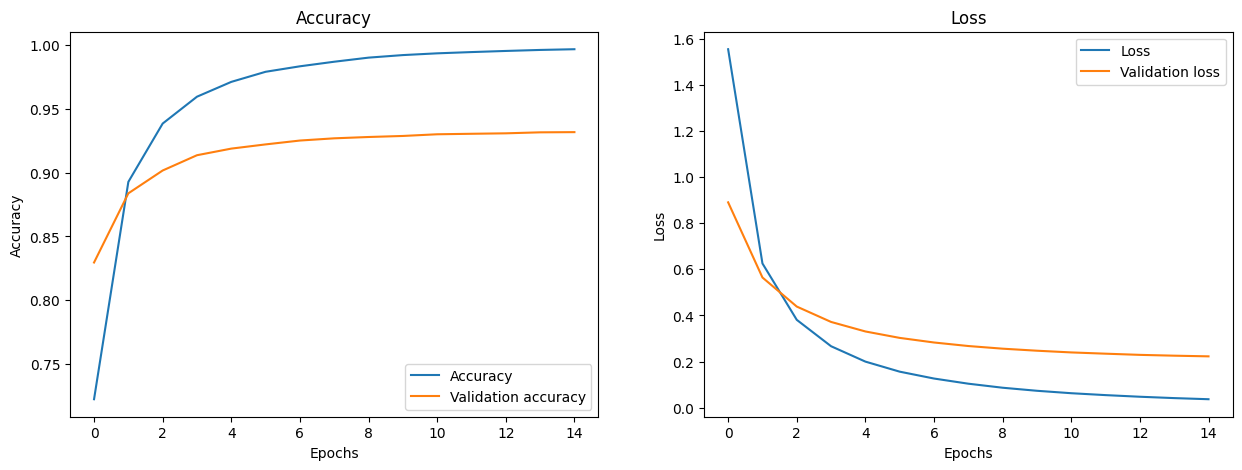

In [ ]:
plot_history(ff_history)

In [ ]:
_, accuracy_ff = evaluate_ff(ff_model, loss_fn, test_dataloader)

In [ ]:
rprint(f"Accuracy (FF): {accuracy_ff * 100:.2f}%")
rprint(f"Δ from baseline: {(accuracy_ff - baseline_accuracy) * 100:.2f}%")
rprint(f"Δ from logistic: {(accuracy_ff - logistic_accuracy) * 100:.2f}%")

Accuracy (FF): 91.91%

Δ from baseline: 4.95%

Δ from logistic: 1.56%

### 2.2 Embeddings

Contruir un modelo con más capas es relativamente sencillo gracias a pytorch. En la red anterior las palabras eran one-hot vectors.

#### ¿Qué problemas ven a esto?

- Matrices repletas de 0's bastante grandes
- No se toma en cuenta posibles relaciones entre los vectores de palabras
- Utilizaremos un modelo de embeddings pre-entrenado


In [ ]:
import gensim.downloader as gensim_api
from gensim.models.keyedvectors import KeyedVectors

In [ ]:
rprint(gensim_api.info()['models'].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 
'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 
'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', 
'__testing_word2vec-matrix-synopsis'])

In [ ]:
vectors = gensim_api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def get_embeddings(model: KeyedVectors) -> dict[str, torch.FloatTensor]:
    """Obtiene los embeddings de las palabras del modelo

    Parameters
    ----------
    model: KeyedVectors
        Modelo de embeddings

    Return
    ------
    dict[str, torh.FloatTensor]
        Diccionario con las palabras como keys y los embeddings como values
    """
    embeddings = {}
    for word, idx in model.key_to_index.items():
        embeddings[word] = torch.FloatTensor(vectors[idx].copy())
    return embeddings

In [ ]:
embeddings = get_embeddings(vectors)

In [ ]:
corpus_words = [
    value.lower() for feature in X_train_features
    for value in feature.values()
]
corpus_words = sorted(set(corpus_words))

In [ ]:
embeddings_words = embeddings.keys()
vocabulary = set(corpus_words + list(embeddings_words))

In [ ]:
idx2word = dict(enumerate(vocabulary), start=1)
word2idx = {v: k for k, v in idx2word.items()}

In [ ]:
for train_feature in X_train_features:
    for word in train_feature:
        train_feature[word] = word2idx[train_feature[word].lower()]

In [ ]:
for val_feature in X_val_features:
    for word in val_feature:
        val_feature[word] = word2idx.get(val_feature[word].lower(), 0)


In [ ]:
for test_feature in X_test_features:
    for word in test_feature:
        test_feature[word] = word2idx.get(test_feature[word].lower(), 0)

In [ ]:
embedd_vectorizer = DictVectorizer(sparse=False, dtype=np.int64)

X_train_emb = embedd_vectorizer.fit_transform(X_train_features)
X_val_emb = embedd_vectorizer.transform(X_val_features)
X_test_emb = embedd_vectorizer.transform(X_test_features)

In [ ]:
X_train_emb = torch.from_numpy(X_train_emb)
X_val_emb = torch.from_numpy(X_val_emb)
X_test_emb = torch.from_numpy(X_test_emb)

Notemos que las matrices resultantes contienen indices y no one-hot vectors. TODO mostrarlo

In [ ]:
EMBEDDING_DIM = 100

In [ ]:
embedding_table = torch.randn((len(vocabulary) + 1, 100)) / 10

Llenamos la tabla con los valores de los embeddings extraidos de GLoVe si estan en el modelo

In [ ]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

In [ ]:
idx2pos = dict(enumerate(set(y_train_features)))
pos2idx = {v: k for k, v in idx2pos.items()}

Convertimos las etiquetas POS

In [ ]:
y_train_e = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_train_features)))
y_val_e = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_val_features)))
y_test_e = torch.LongTensor(list(map(lambda key: pos2idx.get(key), y_test_features)))

Creamos los objetos para cargar los datasets en la red

In [ ]:
train_dataset = TensorDataset(X_train_emb, y_train_e)
val_dataset = TensorDataset(X_val_emb, y_val_e)
test_dataset = TensorDataset(X_test_emb, y_test_e)

train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2048, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False)

In [ ]:
LR = 0.005
EPOCHS = 10

In [ ]:
class EmbeddingsModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 num_classes: int,
                 freeze_embeddings: bool = False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings
            )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(5 * embedding_table.size(dim=1), num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        flatten = self.flatten(embeds)
        logist = self.linear(flatten)
        return logist

In [ ]:
embeddings_model = EmbeddingsModel(embedding_table, len(pos2idx)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(embeddings_model.parameters(), lr=LR)

#### Training loop (with embeddings)

In [ ]:
from tqdm.notebook import trange, tqdm

In [ ]:
MODELS_PATH = "/content/drive/MyDrive/models/pos_taggers/embeddings"

In [ ]:
emb_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
for epoch in trange(EPOCHS):
    train_loss, train_acc, batch_count = 0, 0, 0
    embeddings_model.train()
    for X_batch, y_batch in tqdm(train_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        batch_count += 1
        y_batch_pred = embeddings_model(X_batch)
        loss = loss_fn(y_batch_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (sum(torch.argmax(y_batch_pred, dim=-1) == y_batch) / y_batch.size(dim=0)).item()
        train_loss += loss.item()
    embeddings_model.eval()
    with torch.no_grad():
        emb_history["accuracy"].append(train_acc / batch_count)
        emb_history["loss"].append(train_loss / batch_count)
        # Reutilizamos la función de evaluación de FF
        val_loss, val_acc = evaluate_ff(embeddings_model, loss_fn, val_dataloader)
        emb_history["val_loss"].append(val_loss)
        emb_history["val_accuracy"].append(val_acc)
    torch.save(embeddings_model.state_dict(), f"{MODELS_PATH}/pos_tagger_emb_{device}_{epoch}.pth")
torch.save(emb_history, f"{MODELS_PATH}/pos_tagger_emb.history")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

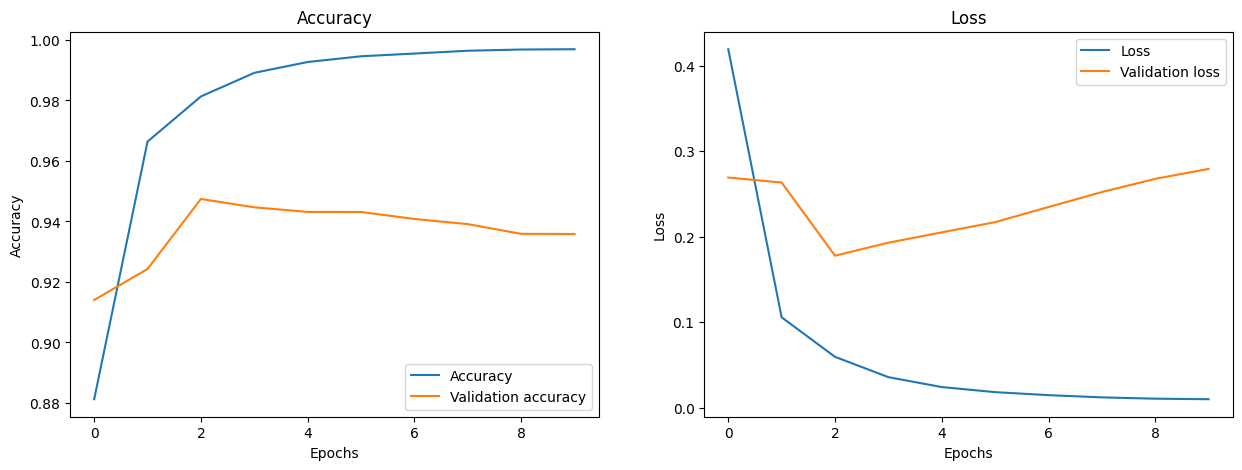

In [ ]:
plot_history(emb_history)

In [ ]:
_, accuracy_emb = evaluate_ff(embeddings_model, loss_fn, test_dataloader)
rprint(f"Accuracy (Embeddings): {accuracy_emb * 100:.2f}%")
rprint(f"Δ from baseline: {(accuracy_emb - baseline_accuracy) * 100:.2f}% ({baseline_accuracy * 100:.2f}%)")
rprint(f"Δ from logistic: {(accuracy_emb - logistic_accuracy) * 100:.2f}% ({logistic_accuracy * 100:.2f}%)")
rprint(f"Δ from ff: {(accuracy_emb - accuracy_ff) * 100:.2f}% ({accuracy_ff * 100:.2f}%)")

Accuracy (Embeddings): 92.31%

Δ from baseline: 5.35% (86.96%)

Δ from logistic: 1.96% (90.35%)

Δ from ff: 0.40% (91.91%)

## 3. Recurrent Neural Nets (RNNs)

Las redes recurrentes, *Recurrent Neural Networks (RNN)*, son una arquitectura que integra la noción temporal presente en el lenguaje de forma natural.

A diferencia de una red *Feedforward* donde tenemos una ventana fija que varía las *RNNs* representan el contexto mediante conexiones recurrentes, permitiendo que las decisiones del modelo tomen encuenta información de una cantidad variable de palabras en el pasado.


![](https://nextcloud.tepezil.net/apps/files_sharing/publicpreview/XZqZjcnrkttwCF2?file=/&fileId=65865&x=2560&y=1440&a=true&etag=713f6269c3d7bf51a3af36907f7066fa)

> Tomada de Speech and Language Processing (Jurafsky, 2025 *draft*)

En este enfoque las entradas serán embeddings de palabras y las salidas serán las distribuciones de probabilidades (generadas por la capa $softmax$) de un conjunto de etiquetas.

Dicho de otro modo, hasta hora hemos predecido las etiquetas en $t_i$ con base en las palabras que le rodean $(w_{i-2}, w_{i-1}, w_{i}, w_{i+1}, w_{i+2})$.

Una mejora a considerar podría ser incluir las predicciones previas en el vector de características para tener más información en el contexto:

$$
P(t_i|w_{i-2}, w_{i-1}, w_{i}, w_{i+1}, w_{i+2},t_{i-2},t_{i-1})
$$

### Sabores de RNNs

Las RNNs son bastante flexibles y no se limitan a considerar la entrada de la red los embeddings de palabras y la salida vectores útiles para predecir etiquetas, palabras o secuencias.

#### Stacked RNNs

Las salidas de una RNN se pueden utilizar como secuencias de entrada de otras RNNs teniendo como resultado *Stacked RNNs*. Esta arquitectura consiste en multiples redes recurrentes donde la salida de una red servirá como entrada de otra.

Generalmente las *stacked RNNs* son mejores que las RNNs de una sola capa. Una razón de esto podría ser que la red considera representaciones a diferentes niveles de abstracción a traves de las capas. Sin embargo, con forme aumenta el número de *stacks* el costo de entrenamiento aumenta rápidamente.

![](https://lena-voita.github.io/resources/lectures/lang_models/neural/rnn/multi_layer-min.png)

> Tomada de Lena Voita, [language modeling](https://lena-voita.github.io/nlp_course/language_modeling.html)

#### Bidirectional RNNs

Las RNNs usan información del contexto de izquierda a derecha para hacer alguna predicción en $t$. Sin embargo, dependiendo de la aplicación es deseable considerar el contexto de la derecha tambien.

Una forma de hacer esto es unir dos RNNs, una que compute de izquierda a derecha y otra de derecha a izquierda y al final concatenar sus representaciones.

Coinsideremos lo siguiente:

$$
h^{f}_{t} = RNN_{forward}(x_1,...,x_t)
$$

$$
h^{b}_{t} = RNN_{backward}(x_t,...,x_n)
$$

Una *bidirectional RNN* combinará el cómputo de ambas representaciones y las concatenará para obtener una sola representación:

$$
h_t = [h^{f}_{t} \otimes h^{b}_{t}]
$$

dónde $\otimes$ representa la operación *mean vector concatenation*.

Este tipo de redes han probado ser bastante buenas para tareas de clasificación de secuencias.

![](https://nextcloud.tepezil.net/apps/files_sharing/publicpreview/qsr9LeAro8FTJ4L?file=/&fileId=65980&x=2560&y=1440&a=true&etag=b4c980855f2cedc4b5af6fb719dae7e0)

In [ ]:
# Extracting the training set
rprint(train_sent_words[0])
rprint(train_sent_pos[0])

In [ ]:
# Todas las palabras a minusculas para que sea compatible con GLoVe
train_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in train_sent_words]
val_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in val_sent_words]
test_sent_words_rnn = [list(map(str.lower, sentence)) for sentence in test_sent_words]

#### Indices

In [ ]:
corpus_words_rnn = sorted(set([word for sentence in train_sent_words_rnn for word in sentence]))
pos_list_rnn = sorted(set([pos for sentence in train_sent_pos for pos in sentence]))

In [ ]:
embeddings_words_rnn = embeddings.keys()
vocabulary = set(corpus_words_rnn + list(embeddings_words_rnn))

In [ ]:
# Start on 2 because id 0 will be pad simbol and 1 will be UNK
idx2word = dict(enumerate(vocabulary), start=2)
idx2pos = dict(enumerate(pos_list_rnn), start=1)

word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}

In [ ]:
def to_index(corpus: list[list[str]], word2idx: dict[str, int], unk_id: int = 1) -> torch.LongTensor:
    indexes = []
    for sent in corpus:
        sent_indexes = torch.LongTensor(
            list(map(lambda word: word2idx.get(word, unk_id), sent))
        )
        indexes += [sent_indexes]
    return indexes


In [ ]:
t = to_index(train_sent_words_rnn[:2], word2idx)

In [ ]:
for sent in t:
    for word in sent:
        print(idx2word[int(word)])

aesthetic
appreciation
and
spanish
art
:
insights
from
eye
-
tracking


In [ ]:
X_train_idx_rnn = to_index(train_sent_words_rnn, word2idx)
Y_train_idx_rnn = to_index(train_sent_pos, pos2idx)

In [ ]:
X_val_idx_rnn = to_index(val_sent_words_rnn, word2idx)
Y_val_idx_rnn = to_index(val_sent_pos, pos2idx)

In [ ]:
X_test_idx_rnn = to_index(test_sent_words_rnn, word2idx)
Y_test_idx_rnn = to_index(test_sent_pos, pos2idx)

#### Padding

In [ ]:
from torch.nn.utils.rnn import pad_sequence

In [ ]:
pad_sequence(X_train_idx_rnn[41:43], batch_first=True, padding_value=0)

tensor([[ 25758, 116092, 203610, 379464, 225462, 261110, 246080, 246081,  33066,
         112866,  97527, 378517, 117138,  11534, 250417,  21632, 108925,  71266,
          33171, 293345, 127045,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0],
        [398395,  33066, 112866,  51535, 382534, 366752, 227738, 298152, 373204,
         203610, 273719, 222196, 203610,  11534, 104665, 337062, 128253,  33066,
         115740, 356127, 146660, 377595,  27140, 249503, 203610, 209572, 203610,
          21632, 122953, 338638, 211114, 101591, 127045]])

In [ ]:
X_train_rnn = pad_sequence(X_train_idx_rnn, batch_first=True, padding_value=0)
Y_train_rnn = pad_sequence(Y_train_idx_rnn, batch_first=True, padding_value=0)

In [ ]:
X_val_rnn = pad_sequence(X_val_idx_rnn, batch_first=True, padding_value=0)
Y_val_rnn = pad_sequence(Y_val_idx_rnn, batch_first=True, padding_value=0)

In [ ]:
X_test_rnn = pad_sequence(X_test_idx_rnn, batch_first=True, padding_value=0)
Y_test_rnn = pad_sequence(Y_test_idx_rnn, batch_first=True, padding_value=0)

#### Embeddings para RNN

In [ ]:
EMBEDDING_DIM = 100

In [ ]:
embedding_table = torch.randn((len(vocabulary) + 2, EMBEDDING_DIM)) / 10

In [ ]:
for word in vocabulary:
    if word in embeddings:
        embedding_table[word2idx[word]] = embeddings[word]

### La Recurrent Neural Net con pytorch

In [ ]:
class RnnModel(nn.Module):
    def __init__(self,
                 embedding_table,
                 hidden_size,
                 num_classes: int,
                 freeze_embeddings: bool = False,
                 num_layers: int=1,
                 bidirectional=False):
        super().__init__()
        embedding_dim = embedding_table.size(dim=-1)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_table,
            freeze=freeze_embeddings,
            padding_idx=0
            )
        self.recurrent = nn.RNN(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True
        )
        if bidirectional:
            # Dos veces las unidades si es bidireccional
            self.linear = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, sentence):
        embeds = self.embedding(sentence)
        rec_out, _ = self.recurrent(embeds)
        logist = self.linear(rec_out)
        return logist

In [ ]:
rnn_model = RnnModel(
    embedding_table,
    hidden_size=128,
    num_classes=len(pos2idx) + 1,
    freeze_embeddings=False,
    num_layers=2,
    bidirectional=True
).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.NAdam(rnn_model.parameters(), lr=0.005)

#### Training loop

In [ ]:
EPOCHS = 10

In [ ]:
train_dataset_rnn = TensorDataset(X_train_rnn, Y_train_rnn)
train_dataloader_rnn = DataLoader(train_dataset_rnn, batch_size=512, shuffle=True)

In [ ]:
val_dataset_rnn = TensorDataset(X_val_rnn, Y_val_rnn)
val_dataloader_rnn = DataLoader(val_dataset_rnn, batch_size=2048, shuffle=False)

In [ ]:
test_dataset_rnn = TensorDataset(X_test_rnn, Y_test_rnn)
test_dataloader_rnn = DataLoader(test_dataset_rnn, batch_size=2048, shuffle=False)

In [ ]:
def evaluate_rnn(model: nn.Module, loss_fn: nn.Module, dataloader: DataLoader):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        accuracy = 0
        t_words = 0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch_pred = model(X_batch)
            current_loss = loss_fn(
                y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
                y_batch.reshape(-1)
            )
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            total_loss += n_words + current_loss.item()
            accuracy += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()
        return total_loss / t_words, accuracy / t_words

In [ ]:
MODELS_PATH = "/content/drive/MyDrive/models/pos_taggers/rnn"

In [ ]:
rnn_history = {"accuracy": [], "loss": [], "val_loss": [], "val_accuracy": []}
for epoch in trange(EPOCHS):
    train_loss, train_acc, t_words = 0, 0, 0
    rnn_model.train()
    for X_batch, y_batch in tqdm(train_dataloader_rnn):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = rnn_model(X_batch)
        loss = loss_fn(
            y_batch_pred.reshape(-1, y_batch_pred.size(dim=-1)),
            y_batch.reshape(-1)
            )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            n_words = torch.sum(y_batch > 0).item()
            t_words += n_words
            train_loss += n_words * loss.item()
            train_acc += torch.mul(
                torch.argmax(y_batch_pred, dim=-1) == y_batch,
                y_batch > 0).sum().item()

    rnn_model.eval()
    with torch.no_grad():
        rnn_history["accuracy"].append(train_acc / t_words)
        rnn_history["loss"].append(train_loss / t_words)
        val_loss, val_acc = evaluate_rnn(rnn_model, loss_fn, val_dataloader_rnn)
        rnn_history["val_loss"].append(val_loss)
        rnn_history["val_accuracy"].append(val_acc)
    torch.save(rnn_model.state_dict(), f"{MODELS_PATH}/pos_tagger_rnn_{device}_{epoch}.pth")
torch.save(rnn_history, f"{MODELS_PATH}/pos_tagger_rnn.history")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

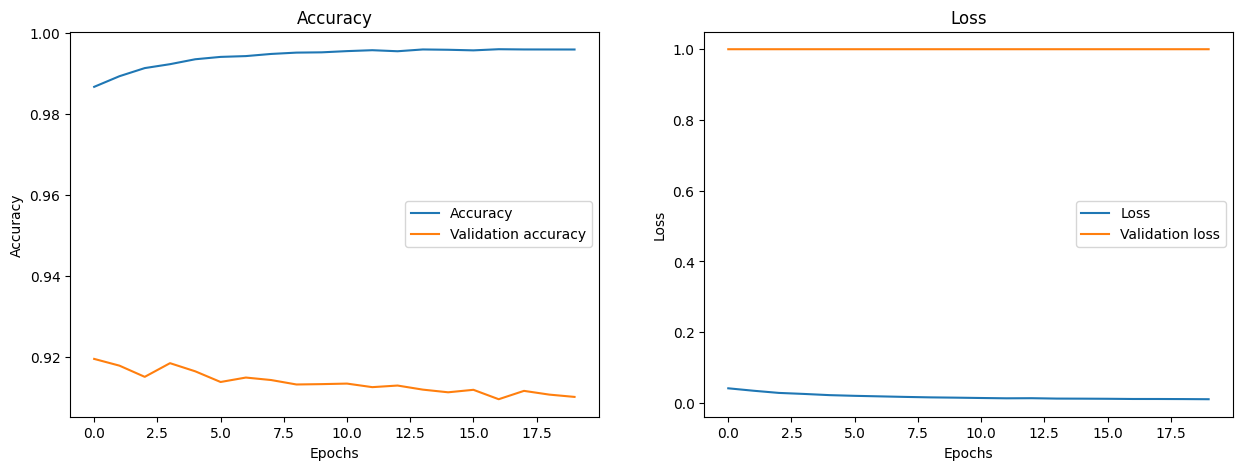

In [ ]:
plot_history(rnn_history)

In [ ]:
_, accuracy_rnn = evaluate_rnn(rnn_model, loss_fn, test_dataloader_rnn)
rprint(f"Accuracy (RNN): {accuracy_rnn * 100:.2f}%")
rprint(f"Δ accuracy (from baseline): {(accuracy_rnn - baseline_accuracy) * 100:.2f}%")
rprint(f"Δ accuracy (from logistic): {(accuracy_rnn - logistic_accuracy) * 100:.2f}% ({logistic_accuracy * 100:.2f}%)")
rprint(f"Δ accuracy (from ff): {(accuracy_rnn - accuracy_ff) * 100:.2f}% ({accuracy_ff * 100:.2f}%)")
rprint(f"Δ accuracy (from embeddings): {(accuracy_rnn - accuracy_emb) * 100:.2f}% ({accuracy_emb * 100:.2f}%)")

Accuracy (RNN): 89.96%

Δ accuracy (from baseline): 3.00%

Δ accuracy (from logistic): -0.39% (90.35%)

Δ accuracy (from ff): -1.95% (91.91%)

Δ accuracy (from embeddings): -2.35% (92.31%)

# Práctica 5: Tech evolution. Caso POS Tagging

**Fecha de entrega: 13 de Abril 2025**

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras
- Realiza una conclusión sobre los resultados observados

### Extra: 0.5pt

- Implementa una red *Long short-term memory units (LSTM)* para la tarea de etiquetado POS
- Reporta el accuracy y comparalo con los resultados de la RNN simple
- Realiza un comentario sobre como impacta la arquitectura LSTM sobre el resultado obtenido

### Referencias

- [Speech and Language Processing 3rd ed. draft (Jurafsky, 2025)](https://web.stanford.edu/~jurafsky/slp3/)
  - [Capítulo 8: RNNs y LSTMs](https://web.stanford.edu/~jurafsky/slp3/8.pdf)
- NLP for you course (Voita, 2023)
  - [Capítulo 3: Language Modeling](https://lena-voita.github.io/nlp_course/language_modeling.html)
- [Python for Natural Language Processing, 3rd edition (Nugues, 2024)](https://link.springer.com/book/10.1007/978-3-031-57549-5)
  - Capítulos 12 (Words, POS and Morphology) y 14 (POS and Sequence annotation)